# EECE568 - Assignment 2

### Mount on Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/ColabNotebooks/EECE_568/Assignment_2/

/content/gdrive/MyDrive/ColabNotebooks/EECE_568/Assignment_2


### Imports

In [ ]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

Running on torch.__version__ =  2.1.0+cu118


### Helper Functions

In [ ]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

# a function to make gray-scale images the same shape as color images
def gray_to_color(x):
    return x.repeat(3, 1, 1)

# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

## Q1

### Dataset and Dataloader

In [ ]:
# Use standard MNIST dataset
class MyDataset(torchvision.datasets.MNIST):
    def __init__(self, *args, debug=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug = debug

    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        img = data[0]
        label = data[1]
        return {'image': img, 'label': label}

    def __len__(self):
        return super().__len__()

dataset = MyDataset(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
    debug=True,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

### ToDo: train, validation, test split

The standard MNIST dataset does not provide a validation set. Use 20% of the training data as the validation set.

The standard MNIST dataset has a test set, and you can download it similar to downloading the train set, only by setting the train label to 'False'. Use the test set only for final the evaluation.

In [ ]:
# ToDo: load the test set
test_dataset = MyDataset(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
    debug=True,
)

In [ ]:
# ToDo: split the training data into train and validation, and define the dataloaders

# 80% of the training data for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

In [ ]:
# ToDo: print the size of train, validation, and test sets
print("Size of training set:", len(train_dataset))
print("Size of validation set:", len(val_dataset))
print("Size of test set:", len(test_dataset))

Size of training set: 48000
Size of validation set: 12000
Size of test set: 10000


### Network

In [ ]:
# an example of using available models in PyTorch
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = torchvision.models.resnet18(num_classes=10)

    def forward(self, input_dict):
        pred_label = self.resnet18(input_dict['image'])
        return {'label': pred_label}

# a simple CNN model, implemented from the scratch
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc = nn.Linear(32*26*26, 10)

    def forward(self, input_dict):
        x = self.conv1(input_dict['image'])
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        pred_label = nn.functional.log_softmax(x, dim=1)

        return {'label': pred_label}

# You can choose either of the defined networks, or define your own neural net
network = MyNetwork().to('cuda')
print(network)

MyNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=21632, out_features=10, bias=True)
)


### Training

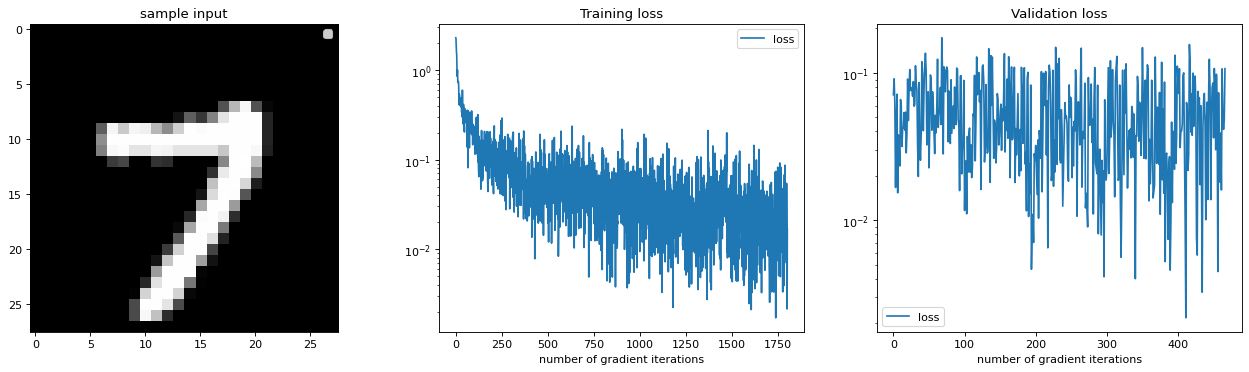

Validation epoch 4, iteration 90 of 94 (95 %), loss=0.10678113996982574


In [ ]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss and backward the gradient
        loss = nn.CrossEntropyLoss()(pred['label'], batch_gpu['label'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(batch_cpu['image'][0:1], ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))

    val_iter = iter(val_loader)
    network.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss = nn.CrossEntropyLoss()(pred['label'], batch_gpu['label'])
            val_losses.append(loss.item())

        if i%10==0:
            axes[2].cla()

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [ ]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)['label'].argmax(dim=1, keepdim=True)
        correct += pred.eq(batch_gpu['label'].view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

In [ ]:
# ToDo: report accuracy on train, validation, and test sets
train_accuracy = get_accuracy(network, train_loader)
val_accuracy = get_accuracy(network, val_loader)
test_accuracy = get_accuracy(network, test_loader)

print(f"Accuracy on Train Set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"Accuracy on Test Set: {test_accuracy * 100:.2f}%")

Accuracy on Train Set: 99.22%
Accuracy on Validation Set: 98.47%
Accuracy on Test Set: 98.49%


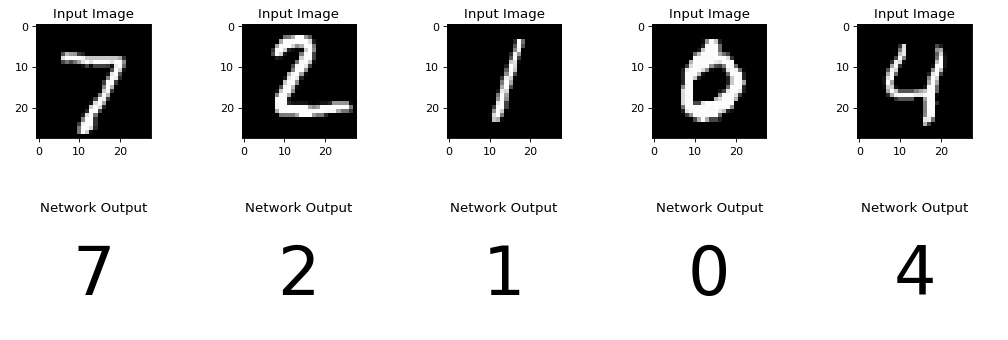

In [ ]:
# ToDo: Plot the input images and output of your network for a few samples in the test set
# Ensure we are in evaluation mode; this can affect layers like dropout and batch normalization
network.eval()

# Get a batch of test data
test_iter = iter(test_loader)
batch_cpu = next(test_iter)
batch_gpu = dict_to_device(batch_cpu, 'cuda')

# Make predictions
with torch.no_grad():  # Turn off gradients to speed up this part
    pred = network(batch_gpu)['label'].argmax(dim=1, keepdim=True).cpu()

# Prepare to plot the input images and network outputs for 5 samples from the test set
fig, axes = plt.subplots(2, 5, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')

for i in range(5):
  plot_images(batch_cpu['image'][i:i+1], ax=axes[0, i])
  axes[0, i].set_title('Input Image')
  axes[1, i].text(0.5, 0.5, str(pred[i].item()), fontsize=60, ha='center', va='center')
  axes[1, i].set_title('Network Output')
  axes[1, i].axis('off')
plt.subplots_adjust(hspace=0.7)

## Q2

### Dataset and Dataloader

In [ ]:
# Use standard MNIST dataset
class AnomalyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.digits = {0:[], 1:[], 2:[], 3:[], 4:[]}
        for idx in range(len(self.data)):
            digit = self.data[idx][1]
            if digit in self.digits.keys():
                self.digits[digit].append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        norm, anomaly = random.sample(list(self.digits.keys()), k=2)
        anomaly_loc, = random.sample([0, 1, 2], k=1)
        norm1_idx, norm2_idx = random.sample(self.digits[norm], k=2)
        anomaly_idx, = random.sample(self.digits[anomaly], k=1)
        if anomaly_loc == 0:
            img0 = self.data[anomaly_idx][0]
            img1 = self.data[norm1_idx][0]
            img2 = self.data[norm2_idx][0]
        elif anomaly_loc == 1:
            img0 = self.data[norm1_idx][0]
            img1 = self.data[anomaly_idx][0]
            img2 = self.data[norm2_idx][0]
        elif anomaly_loc == 2:
            img0 = self.data[norm1_idx][0]
            img1 = self.data[norm2_idx][0]
            img2 = self.data[anomaly_idx][0]

        return {'img0': img0, 'img1': img1, 'img2': img2, 'index': anomaly_loc}

dataset = AnomalyDataset(torchvision.datasets.MNIST(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
))

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

In [ ]:
print('Selected digits and their frequencies:')
for key, value in loader.dataset.digits.items():
    print(key, len(value))

Selected digits and their frequencies:
0 5923
1 6742
2 5958
3 6131
4 5842


### ToDo: train, validation, test split

Use 20% of the training data as the validation set.

The standard MNIST dataset has a test set, and you can download it similar to downloading the train set, only by setting the train label to 'False'. Use the test set only for final the evaluation.

In [ ]:
# ToDo: load the test set
test_dataset = AnomalyDataset(torchvision.datasets.MNIST(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
))

In [ ]:
# ToDo: define the dataloaders

# 80% of the training data for training, 20% for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

In [ ]:
# ToDo: print the size of train, validation, and test sets
print("Size of training set:", len(train_dataset))
print("Size of validation set:", len(val_dataset))
print("Size of test set:", len(test_dataset))

Size of training set: 48000
Size of validation set: 12000
Size of test set: 10000


### ToDo: Network

Implement a neural network that takes three images as input and returns the index of the image with the different digit.

Your network should take a python dictionary as input and extract the input images from it. Your network should return a python dictionaly containing a key named 'index'.

In [ ]:
# ToDo: Implement your neural network from scratch
class MyNetwork2(nn.Module):
    def __init__(self):
        super(MyNetwork2, self).__init__()

        # ToDo: code here
        # Define the layers using the module classes
        # Considered as stateless(no trainable parameters), we can reuse the same MaxPooling and ReLU layer for different conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64*7*7*3, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, input_dict):
        img0 = input_dict['img0']
        img1 = input_dict['img1']
        img2 = input_dict['img2']

        # ToDo: code here
        # Apply the first conv layer
        x0 = self.conv1(img0)
        x0 = self.relu(x0)
        x0 = self.maxpool(x0)
        x1 = self.conv1(img1)
        x1 = self.relu(x1)
        x1 = self.maxpool(x1)
        x2 = self.conv1(img2)
        x2 = self.relu(x2)
        x2 = self.maxpool(x2)

        # Apply the second conv layer
        x0 = self.conv2(x0)
        x0 = self.relu(x0)
        x0 = self.maxpool(x0)
        x1 = self.conv2(x1)
        x1 = self.relu(x1)
        x1 = self.maxpool(x1)
        x2 = self.conv2(x2)
        x2 = self.relu(x2)
        x2 = self.maxpool(x2)

        # Flatten the outputs for the fully connected layers
        x0 = x0.view(x0.size(0), -1)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)

        # Concatenate the flattened outputs
        x = torch.cat((x0, x1, x2), dim=1)

        # Apply the first fully connected layer
        x = self.fc1(x)
        x = self.relu(x)

        # Apply the second fully connected layer
        pred_index = self.fc2(x)

        # The output should be the index of the anomalous digit, which we interpret as a classification problem.
        # Therefore, softmax is not explicitly needed as it will be included in the loss function during training.

        # Hint: use padding in conv layers to adjust the dimensions
        # Hint: max-pooling and ReLU layers can be useful
        # Hint: choose a suitable activation function for the last layer

        return {'index': pred_index}

network = MyNetwork2().to('cuda')
print(network)

MyNetwork2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=9408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


### ToDo: Training

In [ ]:
# ToDo: define a suitable loss function
def my_loss_function(predicted_index, target_index):

  # code here
  criterion = nn.CrossEntropyLoss()
  loss = criterion(predicted_index, target_index)
  return loss

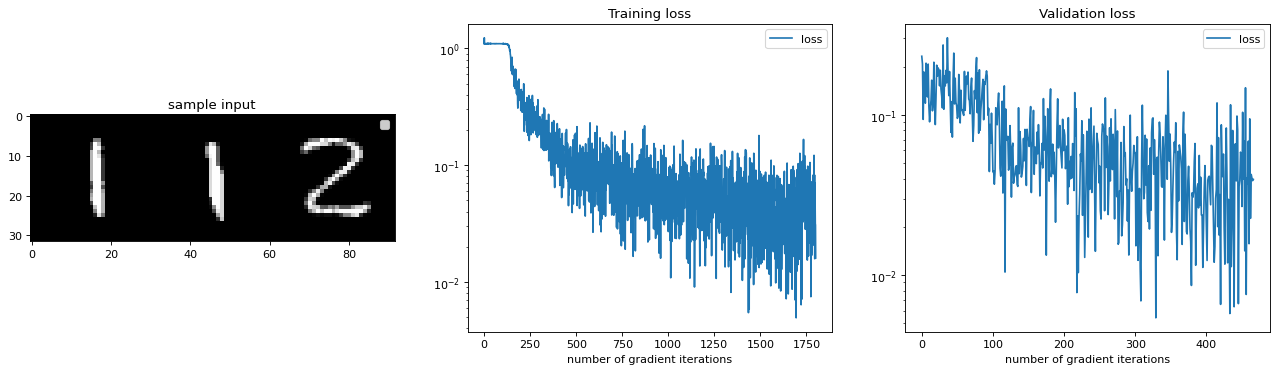

Validation epoch 4, iteration 90 of 94 (95 %), loss=0.039587851613759995


In [ ]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss and backward the gradient
        loss = my_loss_function(pred['index'], batch_gpu['index'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()
            axes[1].cla()

            # plot some sample image inputs
            plot_images(torch.cat((batch_cpu['img0'][0:1], batch_cpu['img1'][0:1], batch_cpu['img2'][0:1]), 0), ax=axes[0])
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))

    val_iter = iter(val_loader)
    network.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss = my_loss_function(pred['index'], batch_gpu['index'])
            val_losses.append(loss.item())

        if i%10==0:
            axes[2].cla()

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [ ]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)['index'].argmax(dim=1, keepdim=True)
        correct += pred.eq(batch_gpu['index'].view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

In [ ]:
# ToDo: report accuracy on train, validation, and test sets
train_accuracy = get_accuracy(network, train_loader)
val_accuracy = get_accuracy(network, val_loader)
test_accuracy = get_accuracy(network, test_loader)

print(f"Accuracy on Train Set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"Accuracy on Test Set: {test_accuracy * 100:.2f}%")

Accuracy on Train Set: 98.54%
Accuracy on Validation Set: 98.64%
Accuracy on Test Set: 98.87%


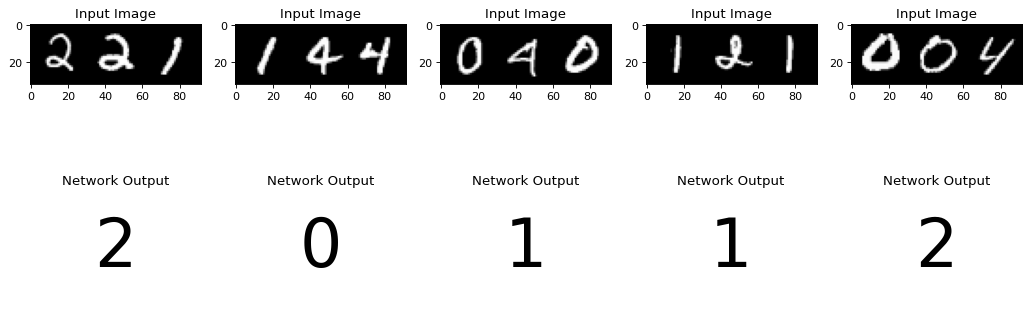

In [ ]:
# ToDo: Plot the input images and output of your network for a few samples in the test set
# Ensure we are in evaluation mode; this can affect layers like dropout and batch normalization
network.eval()

# Get a batch of test data
test_iter = iter(test_loader)
batch_cpu = next(test_iter)
batch_gpu = dict_to_device(batch_cpu, 'cuda')

# Make predictions
with torch.no_grad():  # Turn off gradients to speed up this part
    pred = network(batch_gpu)['index'].argmax(dim=1, keepdim=True).cpu()

# Prepare to plot the input images and network outputs for 5 samples from the test set
fig, axes = plt.subplots(2, 5, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')

for i in range(5):
    plot_images(torch.cat((batch_cpu['img0'][i:i+1], batch_cpu['img1'][i:i+1], batch_cpu['img2'][i:i+1]), 0), ax=axes[0, i])
    axes[0, i].set_title('Input Image')
    axes[1, i].text(0.5, 0.5, str(pred[i].item()), fontsize=60, ha='center', va='center')
    axes[1, i].set_title('Network Output')
    axes[1, i].axis('off')
plt.subplots_adjust(hspace=0.7)

## Q3

### Load and Tokenize Data

In [ ]:
data = pd.read_csv('./imdb_processed.csv')
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [ ]:
# obtain list of words
words = ' '.join(data.processed.values).split()

# check our list
words[30:40]

[',',
 'show',
 'faint',
 'hearted',
 'timid',
 '.',
 'This',
 'show',
 'pull',
 'punch']

In [ ]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
token2word = dict(enumerate(vocab, 1))
token2word[0] = '<PAD>'
word2token = {word: id for id, word in token2word.items()}

In [ ]:
# tokenize reviews
reviews = data.processed.values
reviews_tokenized = [[word2token[word] for word in review.split()] for review in tqdm(reviews)]

# padding sequences
def pad_features(reviews, pad_id, seq_length):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

features = pad_features(reviews_tokenized, pad_id=word2token['<PAD>'], seq_length=256)

print('number of reviews:', len(reviews_tokenized))
print('seq_length:', len(features[0]))

# print first-5 words of first 3 reviews
print('\n first-five words of the first-three reviews:')
print('===============')
features[:3, :5]

100%|██████████| 50000/50000 [00:01<00:00, 25298.70it/s]


number of reviews: 50000
seq_length: 256

 first-five words of the first-three reviews:


array([[ 191, 1083,  930,   81, 3724],
       [  47,  328,   59,  244,    1],
       [   3,   95,  328,   30, 1041]])

### Dataloader

In [ ]:
# we use 70%, 15%, 15% for train, validation, and test sets
train_size = .7
val_size = .5
labels = data.label.to_numpy()

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, labels):
        self.data = torch.utils.data.TensorDataset(torch.from_numpy(reviews), torch.from_numpy(labels).float())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = self.data[index][0]
        label = self.data[index][1]

        return {'review': review, 'label': label}


train_set = MyDataset(train_x, train_y)
val_set = MyDataset(val_x, val_y)
test_set = MyDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=128)

### ToDo: Network

Implement a neural network based on Long short-term memory (LSTM) that takes a series of words (a review) as input and returns the label of the review indicating whether it is positive (1) or negative (0).

Your network should take a python dictionary as input and extract the input sentences from it. Your network should return a python dictionaly containing a key named 'label'.

In [ ]:
# ToDo: Implement your neural network
class SentimentLSTM(nn.Module):
    def __init__(self):
        super(SentimentLSTM, self).__init__()

        # ToDo: code here
        self.embedding = nn.Embedding(len(word2token), embedding_dim=400)
        self.lstm = nn.LSTM(input_size=400, hidden_size=256, num_layers=2, dropout=0.5, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

        # Hint: start with an embedding layer
        # Hint: using dropout might be useful
        # Hint: choose a suitable activation function for the last layer


    def forward(self, input_dict):
        x = input_dict['review']

        # ToDo: code here
        x = self.embedding(x)
        lstm_out, hidden = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1])
        out = self.fc(lstm_out)
        pred_label = self.sigmoid(out).squeeze()

        return {'label': pred_label}

network = SentimentLSTM().to('cuda')
print(network)

SentimentLSTM(
  (embedding): Embedding(121301, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### ToDo: Training

In [ ]:
# ToDo: define a suitable loss function
def my_loss_function3(predicted_label, target_label):

  # code here
  criterion = nn.BCELoss()
  loss = criterion(predicted_label, target_label)
  return loss

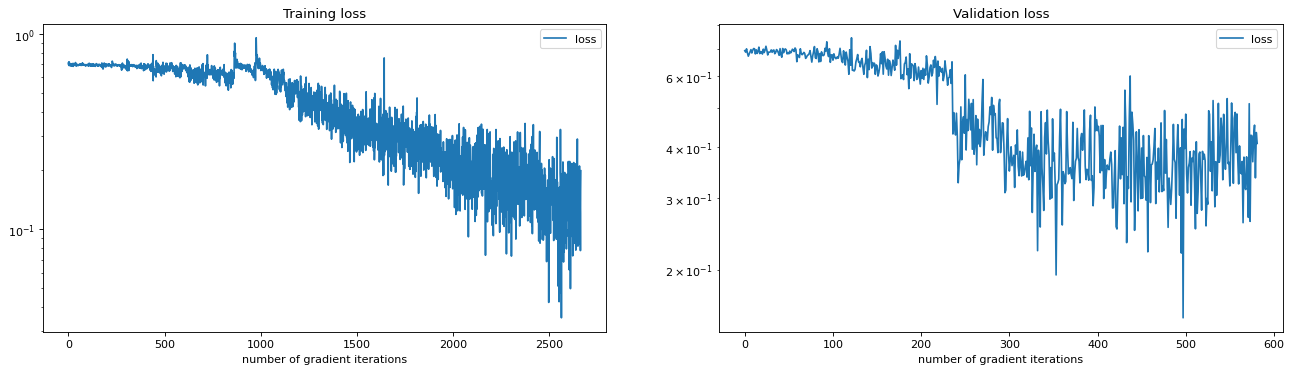

Validation epoch 9, iteration 50 of 59 (84 %), loss=0.408748596906662


In [ ]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss and backward the gradient
        loss = my_loss_function3(pred['label'], batch_gpu['label'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i%100==0:
            axes[0].cla()

            # plot the training error on a log plot
            axes[0].plot(train_losses, label='loss')
            axes[0].set_yscale('log')
            axes[0].set_title('Training loss')
            axes[0].set_xlabel('number of gradient iterations')
            axes[0].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))

    val_iter = iter(val_loader)
    network.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # calculate the loss
        with torch.no_grad():
            loss = my_loss_function3(pred['label'], batch_gpu['label'])
            val_losses.append(loss.item())

        if i%10==0:
            axes[1].cla()

            # plot the validation error on a log plot
            axes[1].plot(val_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Validation loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you might need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [ ]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)['label']
        binary_pred = torch.where(pred < 0.5, 0, 1).squeeze(-1)
        correct += binary_pred.eq(batch_gpu['label']).sum().item()
        total += binary_pred.shape[0]

    return correct / total

In [ ]:
# ToDo: report accuracy on train, validation, and test sets
train_accuracy = get_accuracy(network, train_loader)
val_accuracy = get_accuracy(network, val_loader)
test_accuracy = get_accuracy(network, test_loader)

print(f"Accuracy on Train Set: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Validation Set: {val_accuracy * 100:.2f}%")
print(f"Accuracy on Test Set: {test_accuracy * 100:.2f}%")

Accuracy on Train Set: 96.87%
Accuracy on Validation Set: 86.52%
Accuracy on Test Set: 86.84%


In [ ]:
# ToDo: print the input review and output of your network for one positive
#       example and one negative example in the test set
# TODO: Write a function to visualize test predictions for sentiment analysis
def find_correct_predictions(network, test_loader):
    # Set the network to evaluation mode
    network.eval()
    correct_positive = None
    correct_negative = None

    with torch.no_grad():  # No need to track gradients for evaluation
        test_iter = iter(test_loader)
        for batch in range(len(test_loader)):
            # Get a batch of test data
            batch_cpu = next(test_iter)
            batch_gpu = dict_to_device(batch_cpu, 'cuda')
            labels = batch_cpu['label']

            # Make predictions
            pred = network(batch_gpu)['label'].squeeze().cpu()

            # Convert predictions to binary
            binary_pred = torch.where(pred < 0.5, 0, 1).squeeze(-1)

            for i, (pred, label) in enumerate(zip(binary_pred, labels)):
                if pred == label:
                    sentence = " ".join(token2word.get(idx, '<UNK>') for idx in batch_cpu['review'][i].tolist() if idx != 0)
                    # Check for correct positive prediction
                    if label == 1 and correct_positive is None:
                        correct_positive = sentence
                    # Check for correct negative prediction
                    elif label == 0 and correct_negative is None:
                        correct_negative = sentence

                # Break the loop if both predictions are found
                if correct_positive is not None and correct_negative is not None:
                    return correct_positive, correct_negative

    return correct_positive, correct_negative

# Call the function
correct_positive, correct_negative = find_correct_predictions(network, test_loader)

# Print the results
if correct_positive:
    print("Correctly Predicted Positive Sentence:", correct_positive)
else:
    print("No correctly predicted positive sentence found in the test set.")

if correct_negative:
    print("Correctly Predicted Negative Sentence:", correct_negative)
else:
    print("No correctly predicted negative sentence found in the test set.")

Correctly Predicted Positive Sentence: Barbara Stanwyck sheer delight wartime comedy , sailor invited spend Christmas popular magazine writer family , farm Connecticut . The problem husband , baby , farm , writes column , even cook wonderful recipe provided good friend Uncle Felix , owner Hungarian restaurant New York City . Things get even complicated strict publisher bos invite along Christmas . A scheme hastily planned , stuffy fianc providing actual Connecticut farm , neighbor providing borrowed baby , quick wedding planned publisher looking . But handsome young sailor arrives Christmas Eve , romantic complication ensue , supposedly married author fall like ton brick nice guy Navy man vice versa . This charming , warm film deftly balance humor sentiment wonderful showcase Barbara Stanwyck display considerable comedic talent , aided marvelous character actor Sydney Greenstreet , Una O Connor , S . Z . Sakall , many others . A Christmas night dance town hall toe tapping delight see ,